Git repos analysis
===================

# 1. Read Git contributions

In [ ]:
# PARAMETERS
FILE_TEAMS = 'data/teams-cos40005-fall2025.csv'
  # 'data/teams.csv'
FILE_GIT_TOKEN = 'github-token'
FOLDER_OUTPUT = 'output'
FOLDER_CHART = 'output/charts'

## Library functions

In [2]:
import csv
import os
import pandas as pd
from github import Github
from datetime import datetime

# Function to read the access token from a file
# @requires: access_token is kept in the single-line data file specified by `file_path`
def read_access_token(file_path='token'):
    with open(file_path, 'r') as file:
        token = file.readline().strip()
    return token

# personal access token stored in a file in the current directory
token_path = os.path.join(os.getcwd(), FILE_GIT_TOKEN)
token = read_access_token(token_path)

# Replace 'your_github_token' with your actual GitHub token
# Initialize the GitHub object
g = Github(token)

def read_repo(repo_name):
    # Get the repository
    repo = g.get_repo(repo_name)

    # List to store commit data
    data = []

    # Get commits and iterate through them
    commits = repo.get_commits()
    # sort commits by date
    commits = sorted(commits, key=lambda x: x.commit.author.date)
    for commit in commits:
        if 'merge' in commit.commit.message.lower():
            continue
        commit_data = commit.stats
        commit_info = {
            'date-time': commit.commit.author.date.strftime('%Y-%m-%d %H:%M:%S'),
            'who': commit.commit.author.name,
            'comments': commit.commit.message.replace('\n', ' ').strip(),
            'lines_added': commit_data.additions,
            'lines_deleted': commit_data.deletions
        }
        data.append(commit_info)
    
    return data

def save_data(data, csv_file):
    # Create a DataFrame
    df = pd.DataFrame(data)

    df.to_csv(csv_file, index=False)

    print(f"Data saved to {csv_file}")

def process_teams(file_team):
    with open(file_team, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            team_name = row[0]
            print(f"Processing team {team_name}", end='...\n')
            # some teams have multiple repositories
            repos = row[1].split(';')
            data = []
            
            # read each repo
            for repo in repos:
                print('repo URL: ', repo, end='...')
                repo_name1 = repo.split('/')[-2]
                repo_name2 = repo.split('/')[-1]
                repo_name = f'{repo_name1}/{repo_name2}'
                print('repo name: ', repo_name)
                data += read_repo(repo_name)
            
            # sort data by date-time, add column 'total_lines' = 'lines_added' - 'lines_deleted'
            data = sorted(data, key=lambda x: datetime.strptime(x['date-time'], '%Y-%m-%d %H:%M:%S'))
            
            total_lines = 0
            for row in data:
                line_changes = row['lines_added'] - row['lines_deleted']
                total_lines += line_changes
                row['total_lines'] = total_lines

            save_data(data, f'{FOLDER_OUTPUT}/{team_name}.csv')
            print('done')

## Main (exec)

In [3]:
# if __name__ == '__main__':
process_teams(FILE_TEAMS)

Processing team group-project-may-2025-g1...
repo URL:  https://github.com/COS30049-SUVHN/group-project-fall-2025-gr1...repo name:  COS30049-SUVHN/group-project-fall-2025-gr1
Data saved to output/group-project-may-2025-g1.csv
done
Processing team group-project-may-2025-g2...
repo URL:  https://github.com/COS30049-SUVHN/group-project-fall-2025-gr02...repo name:  COS30049-SUVHN/group-project-fall-2025-gr02
Data saved to output/group-project-may-2025-g2.csv
done


# 2. Generate Git contribution graphs

## Library functions

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
def read_teams(teams_file):
    team_names = []
    with open(teams_file, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            team_names.append(row[0])
    
    return team_names

def process_team(name, team_file):

    df = pd.read_csv(team_file)
    team_name = team_file.split('.')[0]

    # Display the first few rows of the dataframe to understand its structure
    df.head()

    # Convert the date-time column to datetime format
    df['date-time'] = pd.to_datetime(df['date-time'])

    # Draw pie chart for 'who' commit
    commit_counts = df['who'].value_counts()
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)  # Add this line to create a subplot for the pie chart
    commit_counts.plot.pie(autopct='%1.1f%%', startangle=140)
    plt.title('Commit Distribution for ' + team_name)
    plt.ylabel('')

    # Draw line chart for total lines with x-axis as date-time
    plt.subplot(1, 2, 2)
    plt.plot(df['date-time'], df['total_lines'], marker='o')
    plt.title('Total Lines Over Time')
    plt.xlabel('Date-Time')
    plt.ylabel('Total Lines')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    # Save the plot to a file
    plt.savefig(f'{FOLDER_CHART}/{name}.png')

    print(f'Saved analytic chart to: {FOLDER_CHART}/{name}.png')
    
    # plt.show()



## Main (execution)

Saved analytic chart to: output/charts/group-project-may-2025-g1.png
Saved analytic chart to: output/charts/group-project-may-2025-g2.png


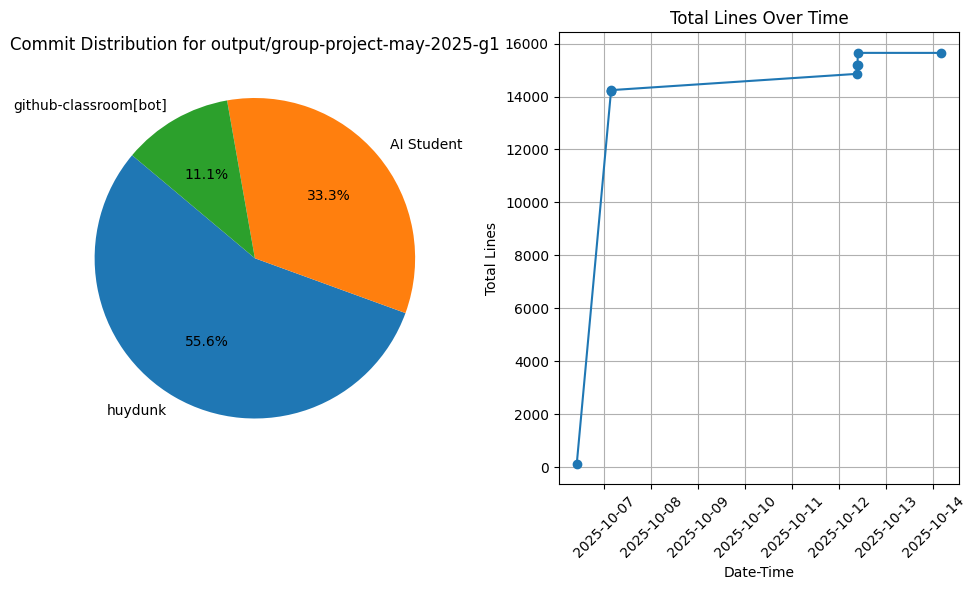

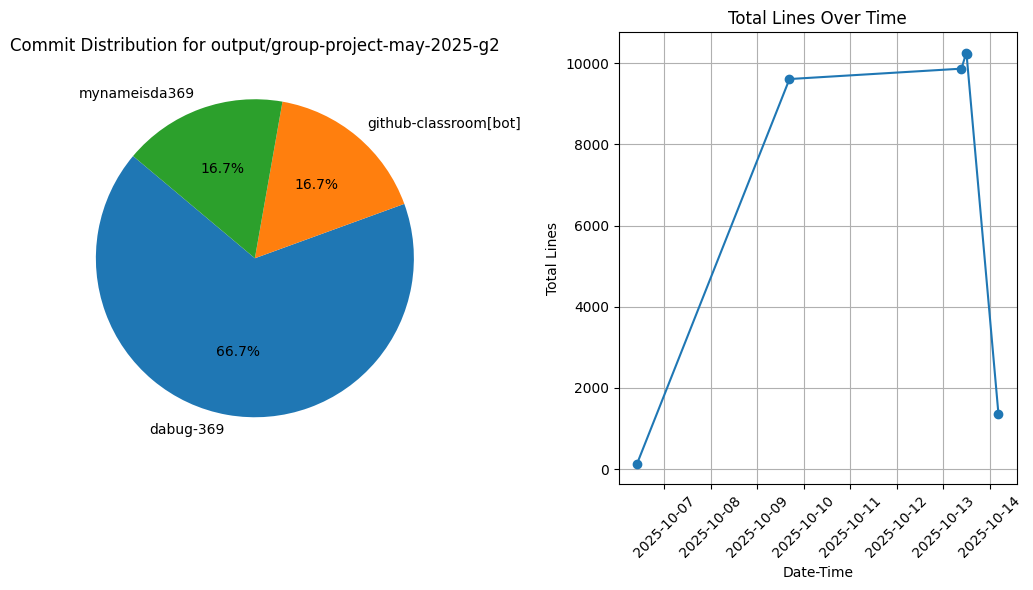

In [5]:
team_names = read_teams('data/teams.csv')
for name in team_names:
    process_team(name, f'output/{name}.csv')

(Chart team member contributions)

In [6]:
# read teams.csv, for each team, read the corresponding csv file
# count total number of commits of all team members, 
# draw pie chart to compare the number of commits of all teams

In [7]:
# import pandas as pd

# import matplotlib.pyplot as plt

# # Read teams.csv
# teams_df = pd.read_csv('data/teams.csv')
# team_commits = {}
# # Iterate over each team
# for team_name in teams_df['Team']:
#     # Read the corresponding csv file
#     file_path = 'output/' + team_name + '.csv'
#     df = pd.read_csv(file_path)
    
#     # Count total number of commits of all team members
#     commit_counts = df['who'].value_counts()
    
#     # Draw pie chart to compare the number of commits of all teams
#     plt.figure(figsize=(8, 6))
#     commit_counts.plot.pie(autopct='%1.1f%%', startangle=140)
#     plt.title('Commit Distribution for ' + team_name)
#     plt.ylabel('')
#     plt.show()